In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

In [2]:
query_df = pd.read_csv('query_dataset.csv')
reference_df = pd.read_csv('reference_dataset.csv')

In [3]:
wavenumbers = query_df.columns[:-1]
query_intensities = query_df[wavenumbers].values
reference_intensities = reference_df[wavenumbers].values

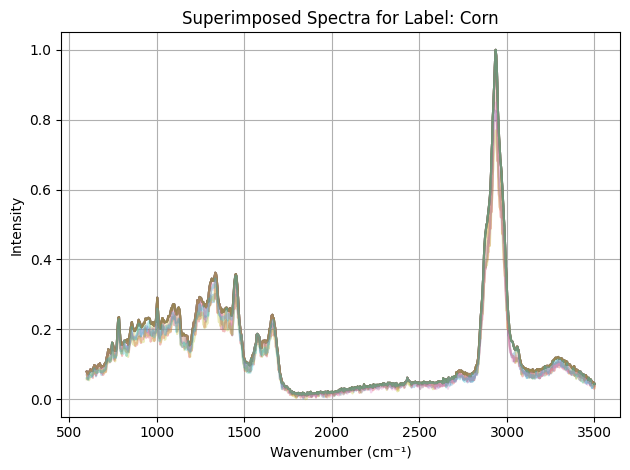

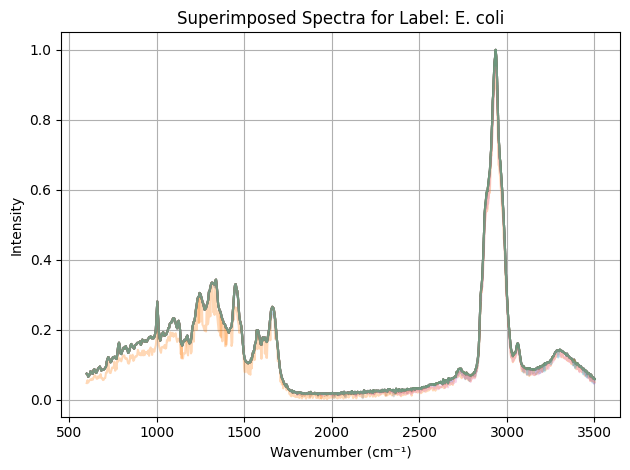

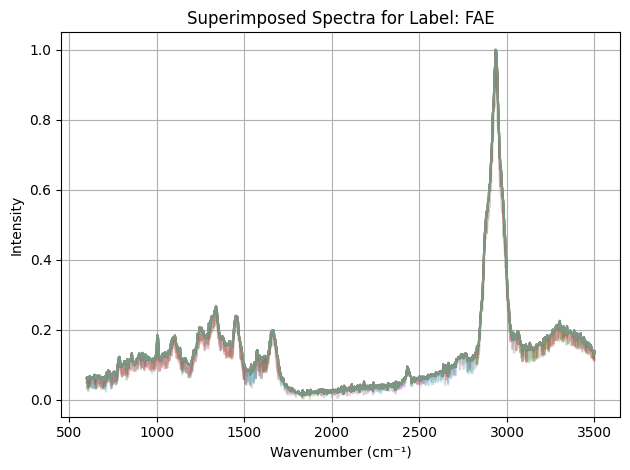

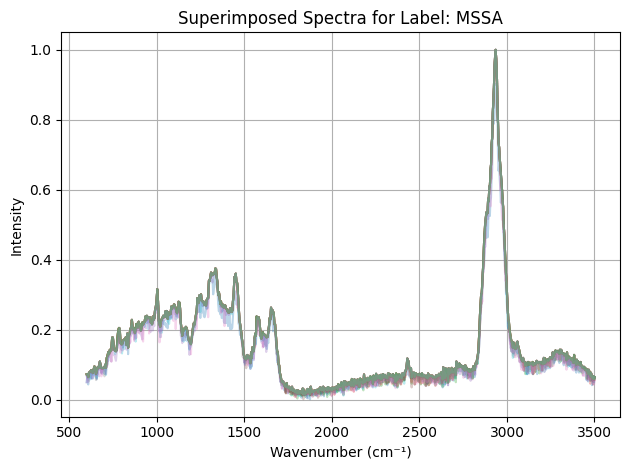

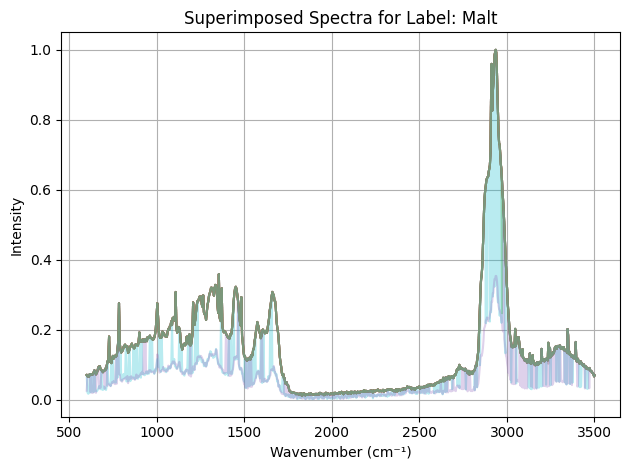

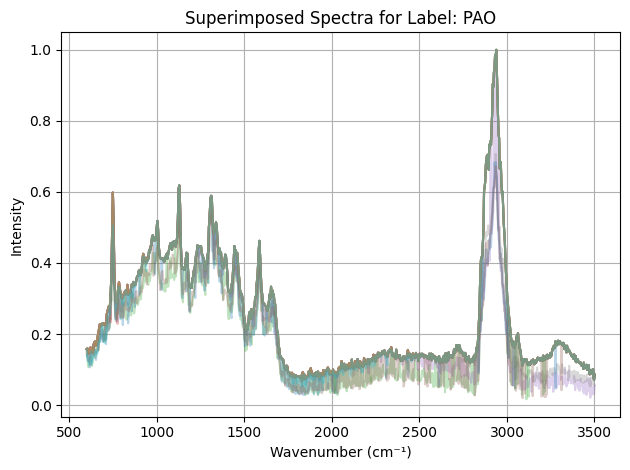

In [4]:

# Extract labels from the reference dataset
reference_labels = reference_df.iloc[:, -1]
unique_labels = reference_labels.unique()

# Plot each label with all spectra superimposed
for label in unique_labels:
    plt.figure()
    spectra = reference_df[reference_df.iloc[:, -1] == label]
    for i in range(spectra.shape[0]):
        plt.plot(wavenumbers.astype(float), spectra.iloc[i, :-1], alpha=0.3)
    plt.title(f'Superimposed Spectra for Label: {label}')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [20]:
def baseline_als(y,lam = 1e6,p = 0.01,niter = 5):
    L = len(y)
    D = np.diff(np.eye(L),2)
    D = lam * (D @ D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w)
        Z = W + D
        baseline = np.linalg.solve(Z,w * y)

        w = p* (y > baseline) + (1-p) * (y < baseline)
    return baseline

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        spec_corr = spec - bkg
        norm = np.linalg.norm(spec_corr)
        out[i] = spec_corr / norm if norm != 0 else spec_corr
    return out

In [ ]:
query_corrected = preprocess(query_intensities)
reference_corrected = preprocess(reference_intensities)

In [22]:
query_proc_df = pd.DataFrame(query_corrected, columns=wavenumbers)
query_proc_df['Species'] = query_df['Species']

reference_proc_df = pd.DataFrame(reference_corrected, columns=wavenumbers)
reference_proc_df['Species'] = reference_df['Species']

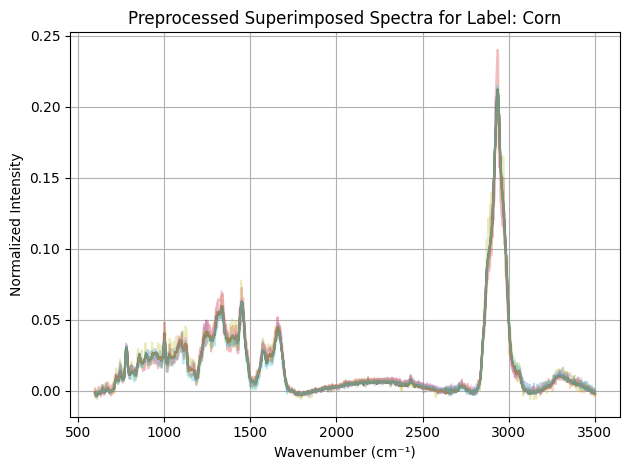

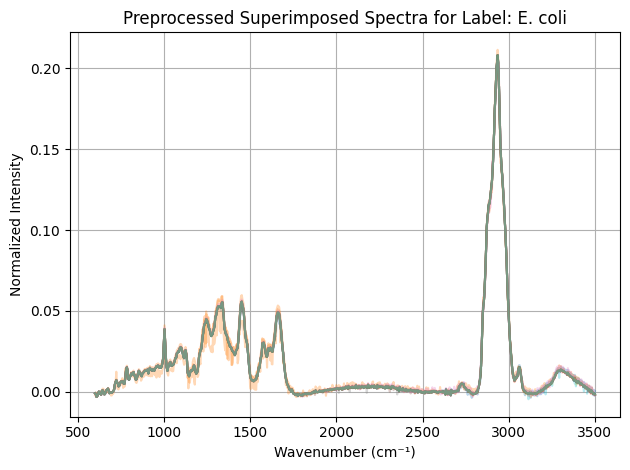

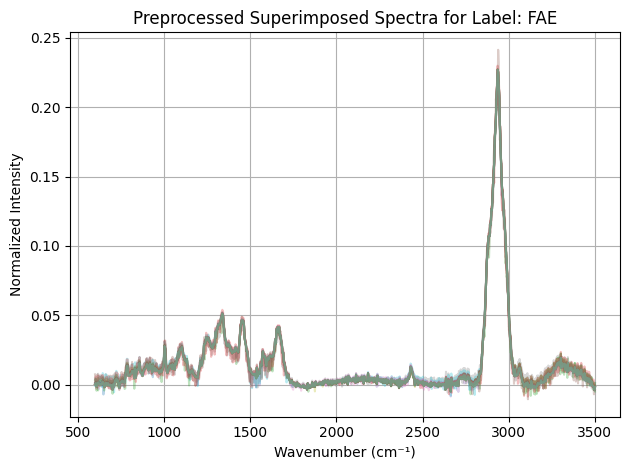

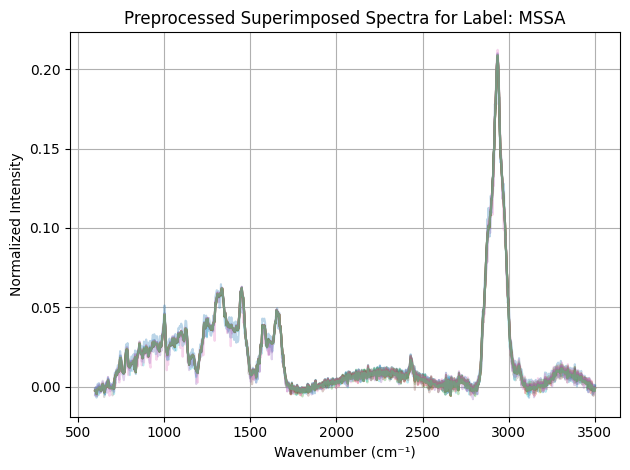

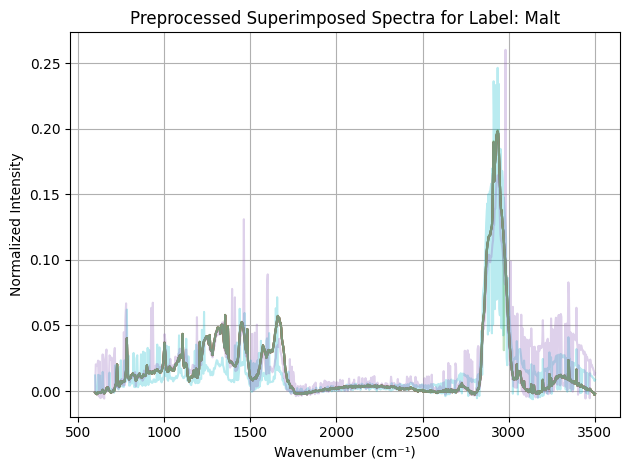

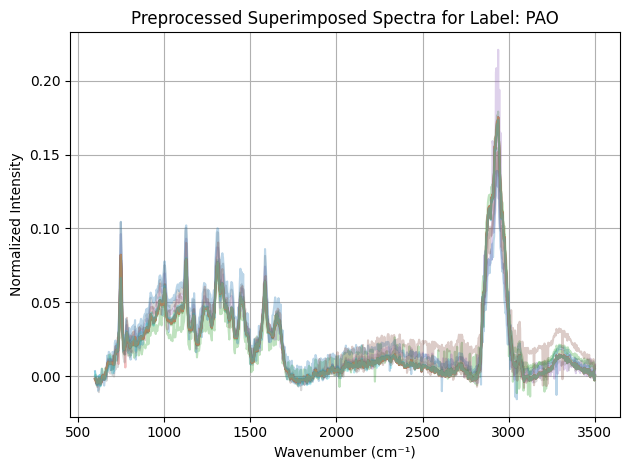

In [23]:
unique_labels = reference_proc_df['Species'].unique()

for label in unique_labels:
    plt.figure()
    spectra = reference_proc_df[reference_proc_df['Species'] == label]
    for i in range(spectra.shape[0]):
        plt.plot(wavenumbers.astype(float), spectra.iloc[i, :-1], alpha=0.3)
    plt.title(f'Preprocessed Superimposed Spectra for Label: {label}')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Normalized Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
raw_query = pd.read_csv('query_dataset.csv')
raw_ref = pd.read_csv('reference_dataset.csv')
wavs = raw_query.columns[:-1]

def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y); D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        baseline = np.linalg.solve(Z, w*y)
        w = p * (y > baseline) + (1-p) * (y < baseline)
    return baseline

def preprocess(intensities):
    out = np.zeros_like(intensities)
    for i, spec in enumerate(intensities):
        bkg = baseline_als(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr/nrm if nrm!=0 else corr
    return out


Q = preprocess(raw_query[wavs].values)
R = preprocess(raw_ref[wavs].values)
dfQ = pd.DataFrame(Q, columns=wavs); dfQ['Species'] = raw_query['Species']
dfR = pd.DataFrame(R, columns=wavs); dfR['Species'] = raw_ref['Species']

In [10]:
K_smooth, N_peak, w_max = 5,11,36
def smooth_spectrum(spec): return np.convolve(spec,np.ones(K_smooth)/K_smooth,mode='same')

def CaPE(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    counts = np.zeros(sm.shape[1], int)
    for s in sm:
        pks, _ = find_peaks(s)
        counts[pks] += 1
    return sorted(np.argsort(counts)[-N_peak:])

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return cp_idxs

def extract_vec(spec, cp_idxs):
    hw = w_max//2
    vec = [spec[max(0,i-hw):min(len(spec),i+hw+1)].max() for i in cp_idxs]
    return minmax_scale(vec)

In [14]:
CPs = {}
compressed_ref = {}
for chem, grp in dfR.groupby('Species'):
    refs = grp[wavs].values
    cp_idxs = CaPE_peak_intensity(refs)
    CPs[chem] = cp_idxs
    compressed_ref[chem] = np.array([extract_vec(s, cp_idxs) for s in refs])

In [15]:
def CaPSim(qv, rvs): return (rvs @ qv).mean()
def identify(spec):
    scores = {}
    for chem, cp in CPs.items():
        qv = extract_vec(spec, cp)
        scores[chem] = CaPSim(qv, compressed_ref[chem])
    best = max(scores, key=scores.get)
    return best, scores


In [16]:
top1_correct = 0
top2_correct = 0
total = len(dfQ)

for _, row in dfQ.iterrows():
    true_label = row['Species']
    
    # 1) Get the raw similarity scores dict, {chem: score}
    scores = identify(row[wavs].values)[1]
    
    # 2) Rank chemicals by score descending
    ranked_chems = sorted(scores, key=scores.get, reverse=True)
    
    # 3) Check top-1
    if true_label == ranked_chems[0]:
        top1_correct += 1
    
    # 4) Check top-2
    if true_label in ranked_chems[:2]:
        top2_correct += 1

# Compute accuracies
top1_accuracy = top1_correct / total
top2_accuracy = top2_correct / total

print(f"Top-1 accuracy over {total} queries: {top1_accuracy:.2%}")
print(f"Top-2 accuracy over {total} queries: {top2_accuracy:.2%}")


Top-1 accuracy over 60 queries: 31.67%
Top-2 accuracy over 60 queries: 33.33%


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 1) Load raw reference data
raw_ref = pd.read_csv('reference_dataset.csv')
wavs_str = raw_ref.columns[:-1]
wavs = wavs_str.astype(float)

# 2) Baseline removal (AsLS) and ℓ₂ normalization 
# Fine-tuning AsLS
def baseline_als(y, lam=1e4, p=0.0001, niter=7):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1-p) * (y < b)
    return b

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

# Apply to reference spectra
refs_raw = raw_ref[wavs_str].values.astype(float)
refs_proc = preprocess(refs_raw)


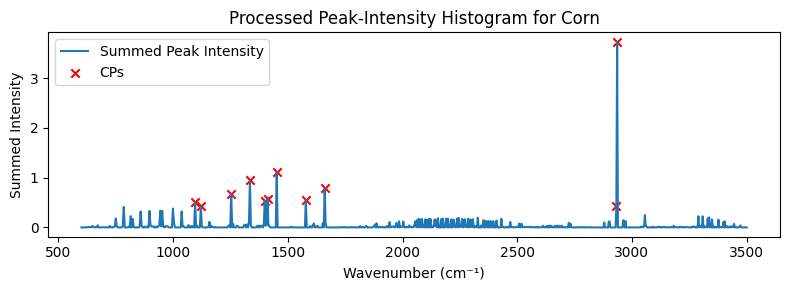

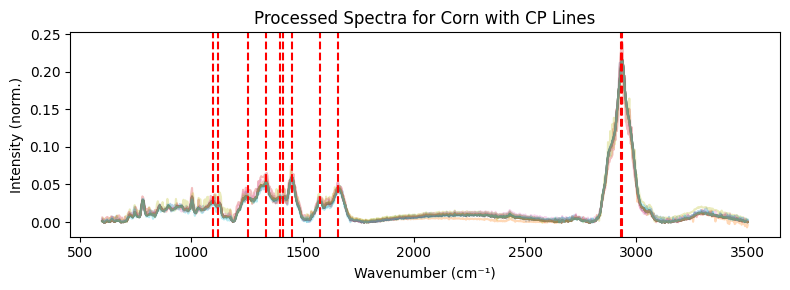

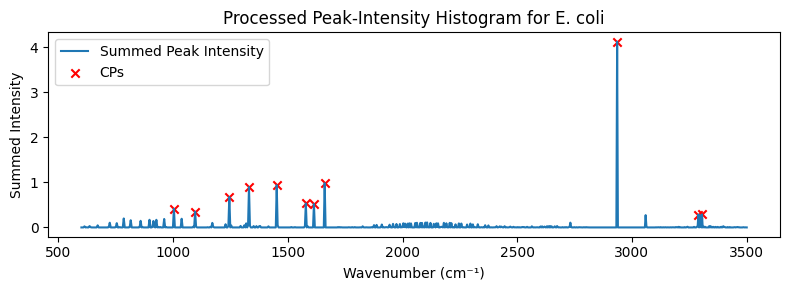

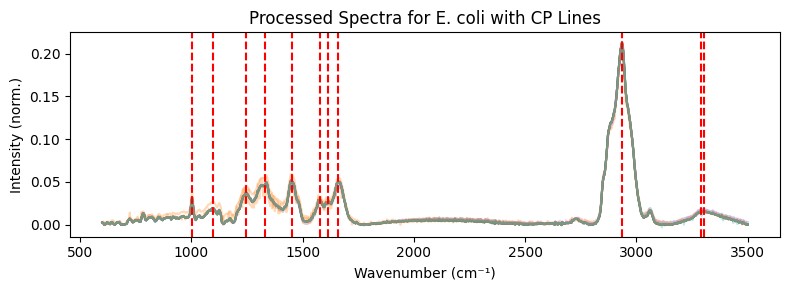

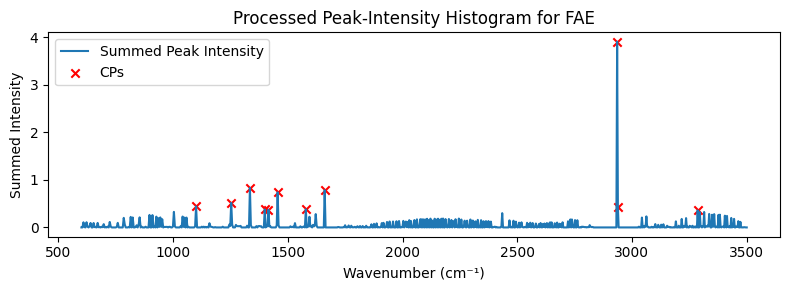

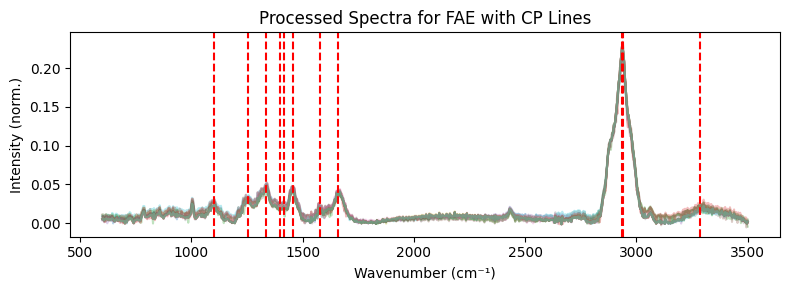

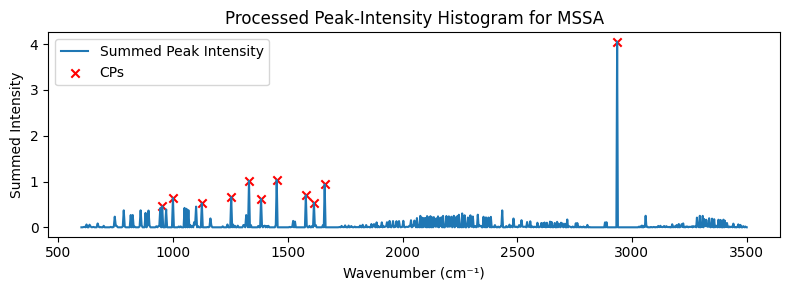

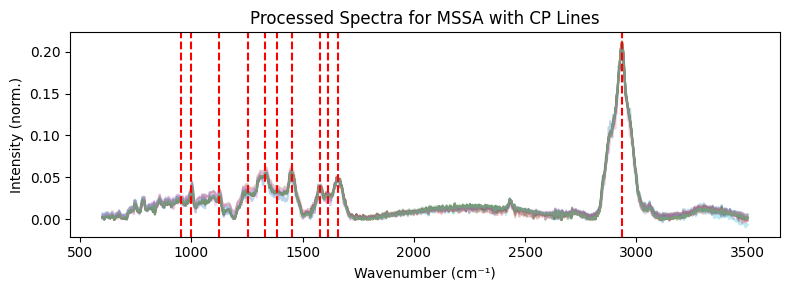

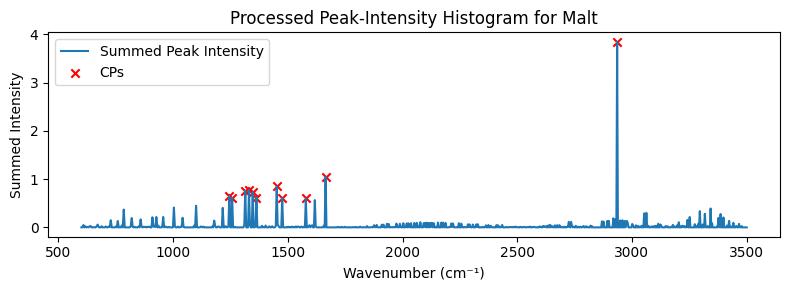

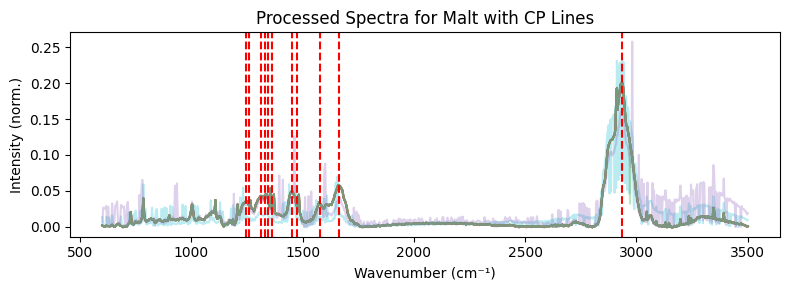

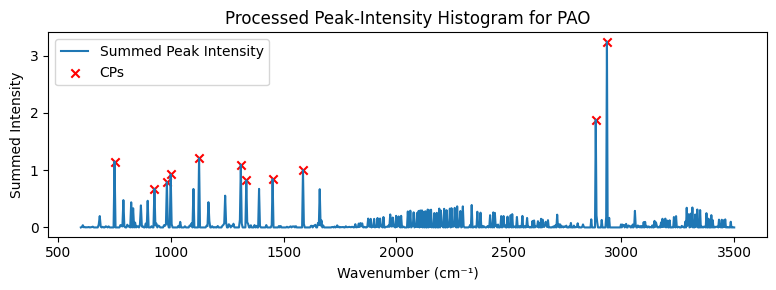

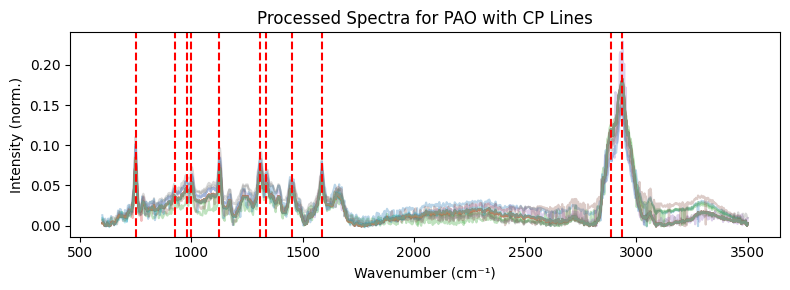

In [70]:
# 3) CaPE on processed data
K_smooth, N_peak = 5, 11

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return peak_intensity, cp_idxs

# 4) Plot for each species (processed)
for chem in sorted(raw_ref['Species'].unique()):
    group = raw_ref[raw_ref['Species']==chem]
    idxs  = group.index.to_list()
    refs_p = refs_proc[idxs]  # pick processed spectra for this species
    
    peak_intensity, cp_idxs = CaPE_peak_intensity(refs_p)
    cp_wavenums = wavs[cp_idxs]
    
    # Peak‐intensity histogram
    plt.figure(figsize=(8,3))
    plt.plot(wavs, peak_intensity, label='Summed Peak Intensity')
    plt.scatter(cp_wavenums, peak_intensity[cp_idxs], color='red', marker='x', label='CPs')
    plt.title(f"Processed Peak‐Intensity Histogram for {chem}")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Summed Intensity')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Overlay processed spectra + CP lines
    plt.figure(figsize=(8,3))
    for spec in refs_p:
        plt.plot(wavs, spec, alpha=0.3)
    for w in cp_wavenums:
        plt.axvline(w, linestyle='--', color='red')
    plt.title(f"Processed Spectra for {chem} with CP Lines")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Intensity (norm.)')
    plt.tight_layout()
    plt.show()

In [71]:
import pandas as pd
import numpy as np

# 1) Load raw data
raw_ref   = pd.read_csv('reference_dataset.csv')
wavs_all  = raw_ref.columns[:-1].astype(float)
mask      = (wavs_all >= 600) & (wavs_all <= 1700)  # keep only fingerprint

# 2) Subset your wavenumbers and raw arrays
wavs       = wavs_all[mask]
wavs_str   = raw_ref.columns[:-1][mask]
refs_raw   = raw_ref[wavs_str].values.astype(float)

# 3) Preprocess (baseline + ℓ₂ norm) on cropped data
def baseline_als(y, lam=1e4, p=0.0001, niter=7):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1-p) * (y < b)
    return b

def preprocess(spectra):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

refs_proc = preprocess(refs_raw)


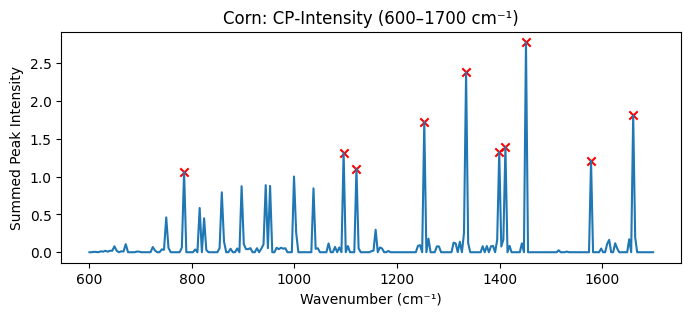

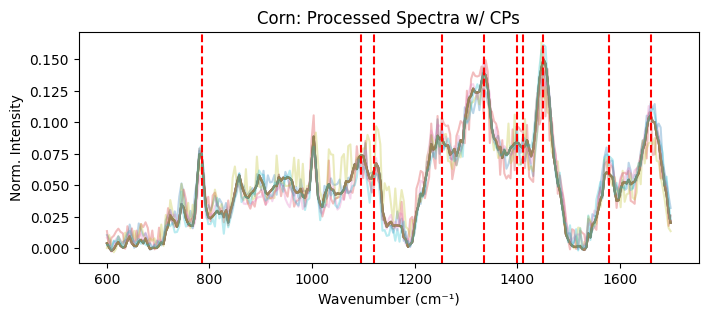

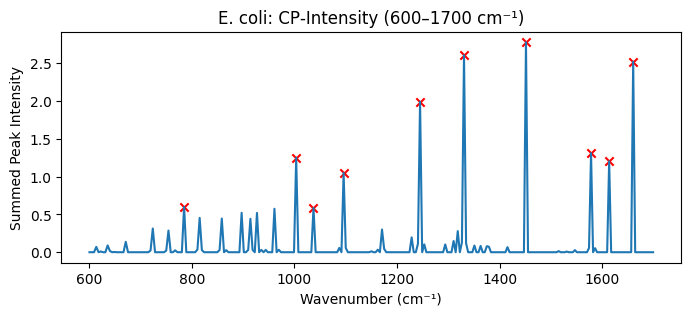

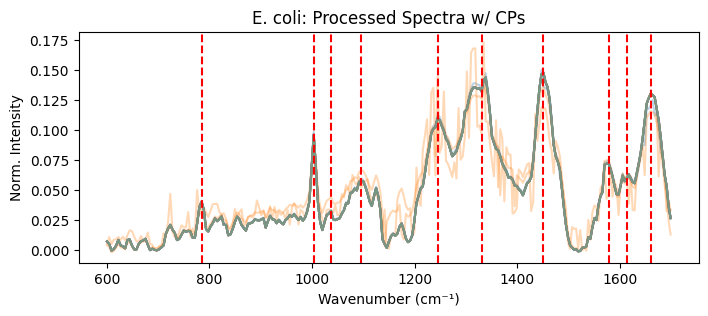

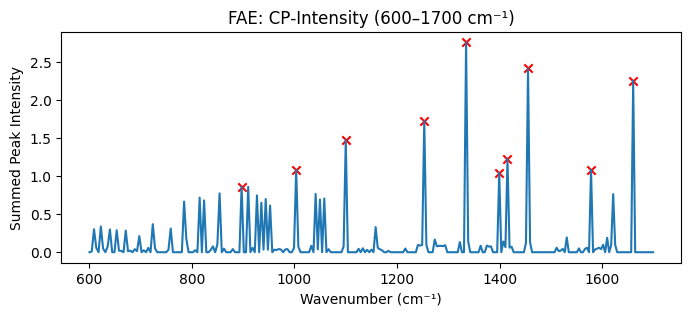

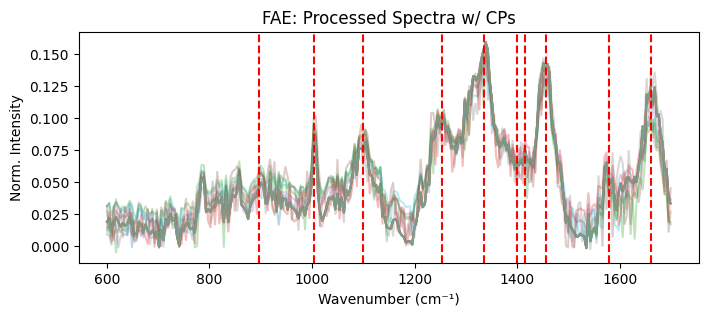

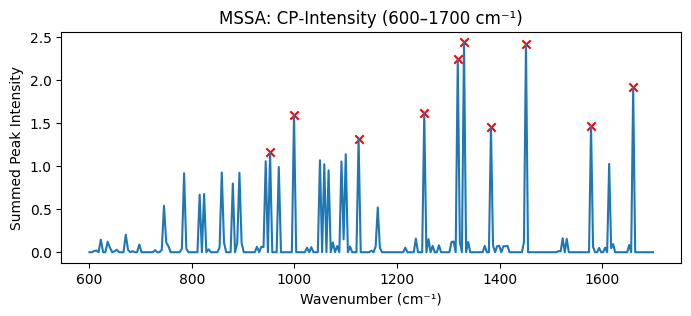

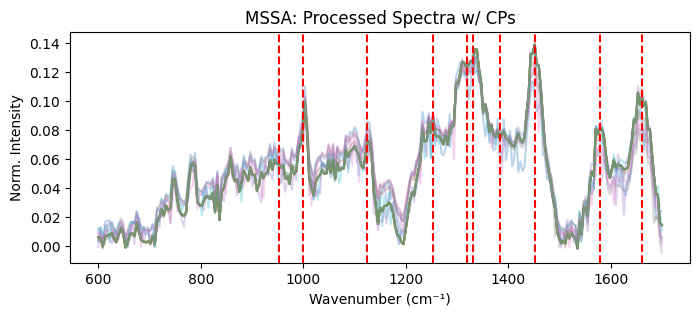

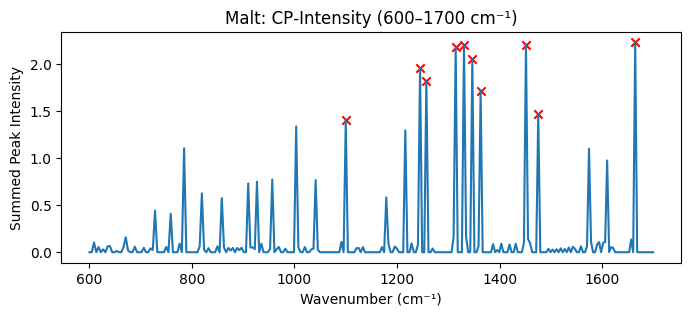

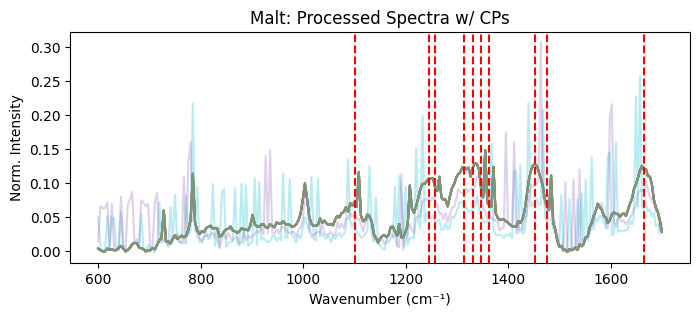

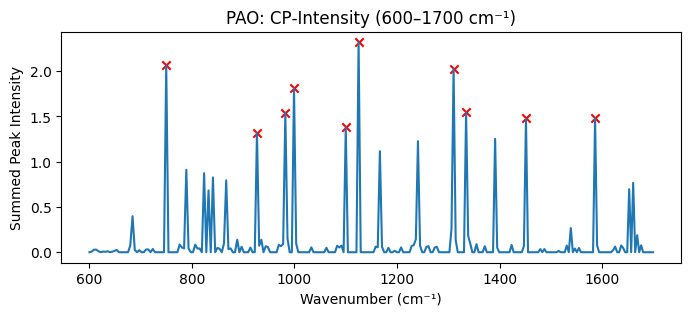

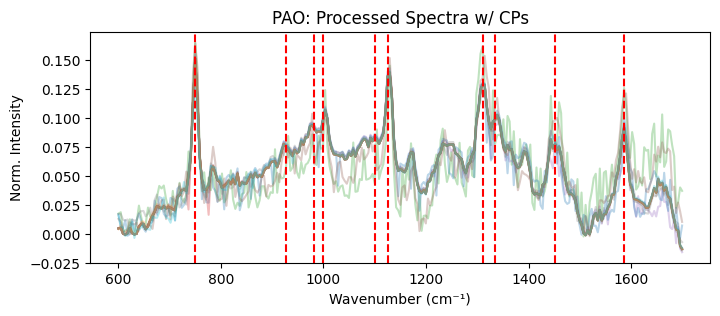

In [72]:
# 4) Run CaPE and plotting on refs_proc using only wavs and wavs_str
K_smooth, N_peak = 5, 10

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return peak_intensity, cp_idxs

import matplotlib.pyplot as plt

for chem in sorted(raw_ref['Species'].unique()):
    idxs  = raw_ref.index[raw_ref['Species']==chem]
    refs_p = refs_proc[idxs]
    
    peak_intensity, cp_idxs = CaPE_peak_intensity(refs_p)
    cp_wavenums = wavs[cp_idxs]
    
    # Plot histogram
    plt.figure(figsize=(8,3))
    plt.plot(wavs, peak_intensity)
    plt.scatter(cp_wavenums, peak_intensity[cp_idxs], color='red', marker='x')
    plt.title(f"{chem}: CP‐Intensity (600–1700 cm⁻¹)")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Summed Peak Intensity')
    plt.show()
    
    # Overlay spectra
    plt.figure(figsize=(8,3))
    for spec in refs_p:
        plt.plot(wavs, spec, alpha=0.3)
    for w in cp_wavenums:
        plt.axvline(w, linestyle='--', color='red')
    plt.title(f"{chem}: Processed Spectra w/ CPs")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Norm. Intensity')
    plt.show()

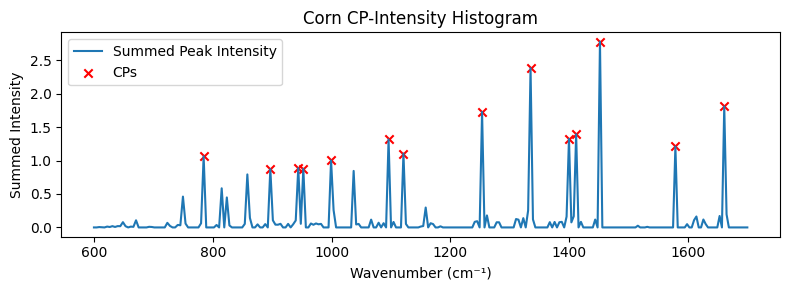

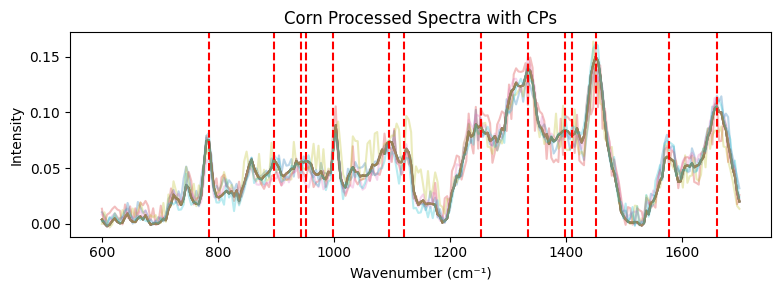

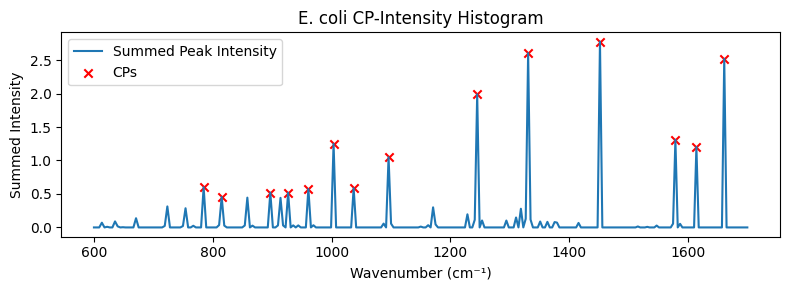

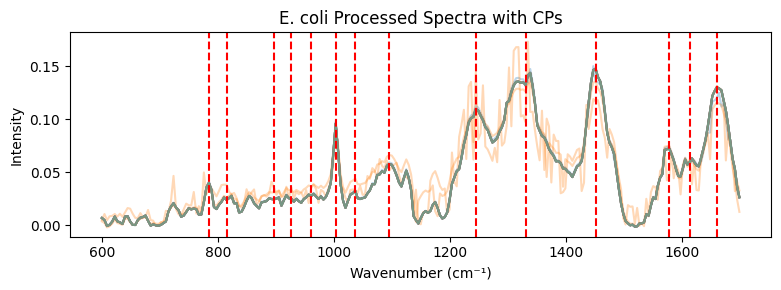

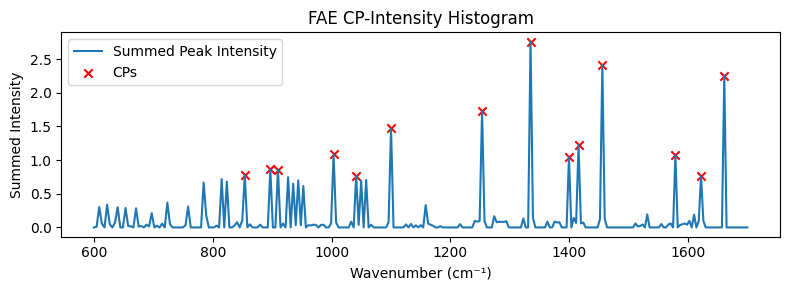

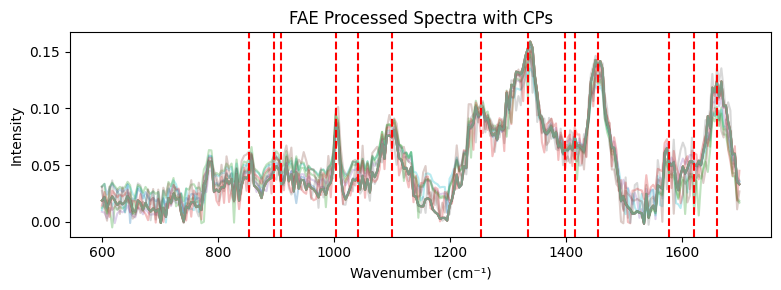

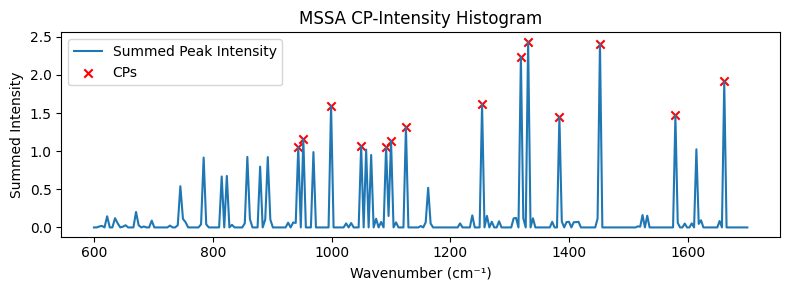

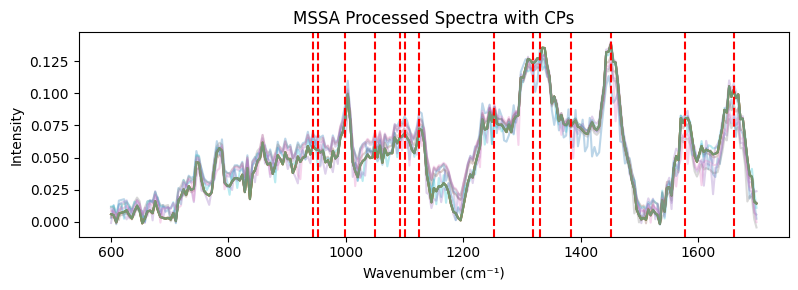

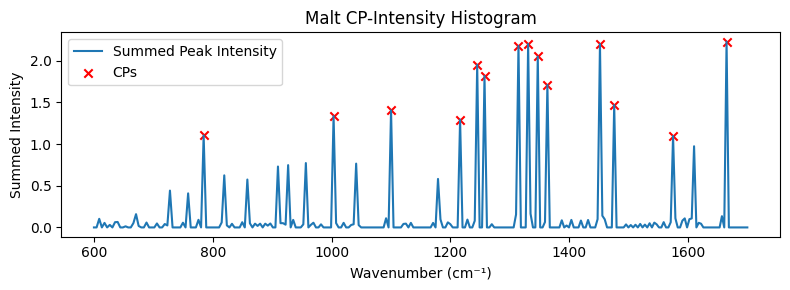

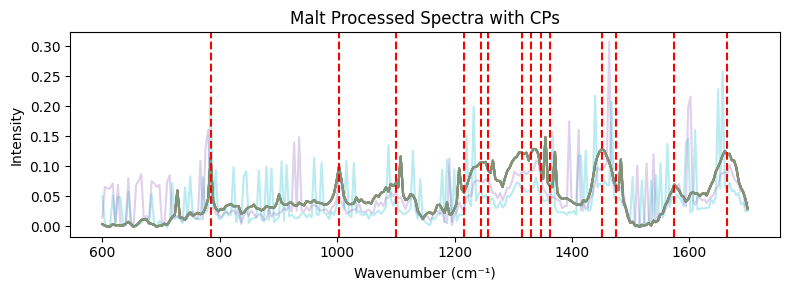

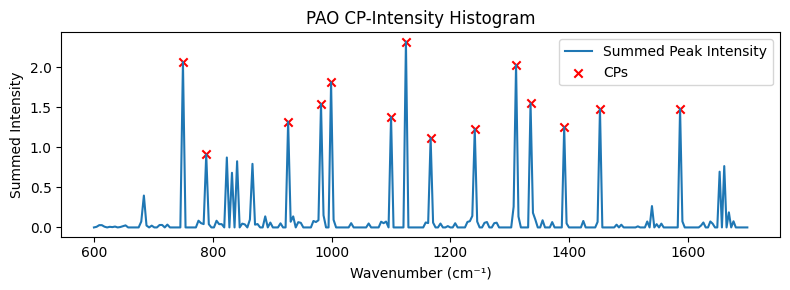

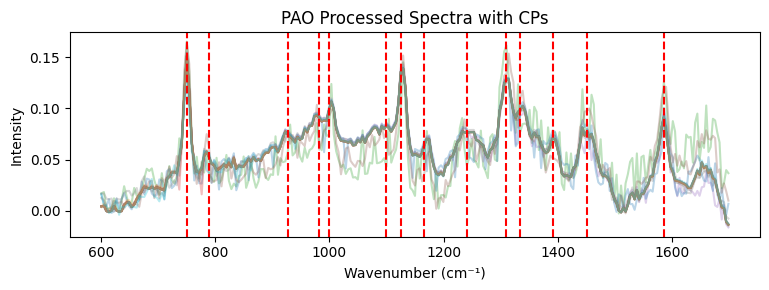

Top-1 accuracy: 33.33%
Top-2 accuracy: 53.33%


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale

# 1) Load raw data
query_df = pd.read_csv('query_dataset.csv')
ref_df   = pd.read_csv('reference_dataset.csv')
wavs_all = query_df.columns[:-1].astype(float)

# 2) Crop to fingerprint region 600–1700 cm⁻¹
mask    = (wavs_all >= 600) & (wavs_all <= 1700)
wavs    = wavs_all[mask]
wavs_str= query_df.columns[:-1][mask]

# 3) Baseline removal (AsLS) and ℓ₂ normalization
def baseline_als(y, lam=1e4, p=0.0001, niter=7):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w)
        Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg  = baseline_als(spec)
        corr = spec - bkg
        nrm  = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out

# Apply preprocess to both datasets
Q_raw = query_df[wavs_str].values.astype(float)
R_raw = ref_df[wavs_str].values.astype(float)
Q_proc = preprocess(Q_raw)
R_proc = preprocess(R_raw)

# Reattach species labels
dfQ = pd.DataFrame(Q_proc, columns=wavs_str); dfQ['Species'] = query_df['Species']
dfR = pd.DataFrame(R_proc, columns=wavs_str); dfR['Species'] = ref_df['Species']

# 4) CaPE parameters & intensity-based extraction
K_smooth, N_peak, w_max = 5, 14, 36

def smooth_spectrum(spec):
    return np.convolve(spec, np.ones(K_smooth)/K_smooth, mode='same')

def CaPE_peak_intensity(refs):
    sm = np.array([smooth_spectrum(s) for s in refs])
    peak_intensity = np.zeros(sm.shape[1])
    for s in sm:
        peaks, _ = find_peaks(s)
        peak_intensity[peaks] += s[peaks]
    cp_idxs = sorted(np.argsort(peak_intensity)[-N_peak:])
    return peak_intensity, cp_idxs

def extract_vec(spec, cp_idxs):
    hw = w_max // 2
    vals = [spec[max(0, i-hw):i+hw+1].max() for i in cp_idxs]
    return minmax_scale(vals)

# 5) Plot CPs for each species
for chem in sorted(dfR['Species'].unique()):
    grp = dfR[dfR['Species']==chem]
    specs = grp[wavs_str].values
    peak_intensity, cp_idxs = CaPE_peak_intensity(specs)
    cp_wavs = wavs[cp_idxs]
    
    # Histogram
    plt.figure(figsize=(8,3))
    plt.plot(wavs, peak_intensity, label='Summed Peak Intensity')
    plt.scatter(cp_wavs, peak_intensity[cp_idxs], color='red', marker='x', label='CPs')
    plt.title(f"{chem} CP-Intensity Histogram")
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Summed Intensity')
    plt.legend(); plt.tight_layout(); plt.show()
    
    # Overlay spectra
    plt.figure(figsize=(8,3))
    for s in specs:
        plt.plot(wavs, s, alpha=0.3)
    for w in cp_wavs:
        plt.axvline(x=w, linestyle='--', color='red')
    plt.title(f"{chem} Processed Spectra with CPs")
    plt.xlabel('Wavenumber (cm⁻¹)'); plt.ylabel('Intensity')
    plt.tight_layout(); plt.show()

# 6) Build CP dictionary and compressed reference library
CPs = {}
compressed_ref = {}
for chem, grp in dfR.groupby('Species'):
    specs = grp[wavs_str].values
    _, cp_idxs = CaPE_peak_intensity(specs)
    CPs[chem] = cp_idxs
    compressed_ref[chem] = np.array([extract_vec(s, cp_idxs) for s in specs])

# 7) CaPSim and identify function
def CaPSim(qv, ref_vs):
    return (ref_vs @ qv).mean()

def identify(spec):
    scores = {chem: CaPSim(extract_vec(spec, CPs[chem]), compressed_ref[chem])
              for chem in CPs}
    best = max(scores, key=scores.get)
    return best, scores

# 8) Evaluate top-1 and top-2 accuracy
top1 = top2 = 0
total = len(dfQ)
for _, row in dfQ.iterrows():
    true = row['Species']
    _, scores = identify(row[wavs_str].values)
    ranked = sorted(scores, key=scores.get, reverse=True)
    if true == ranked[0]: top1 += 1
    if true in ranked[:2]: top2 += 1

print(f"Top-1 accuracy: {top1/total:.2%}")
print(f"Top-2 accuracy: {top2/total:.2%}")


In [8]:
import pandas as pd
import numpy as np
import time

ref_df = pd.read_csv('reference_dataset.csv')
wavs_str = ref_df.columns[:-1]
refs_raw = ref_df[wavs_str].values.astype(float)

def baseline_als(y, lam, p, niter):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        W = np.diag(w); Z = W + D
        b = np.linalg.solve(Z, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(spectra, lam, p, niter):
    out = np.zeros_like(spectra)
    for i, spec in enumerate(spectra):
        bkg = baseline_als(spec, lam, p, niter)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        out[i] = corr / nrm if nrm else corr
    return out


# Time preprocess for first 10 spectra
lam, p, niter = 1e5, 0.01, 10
start = time.perf_counter()
_ = preprocess(refs_raw[:10], lam, p, niter)
end = time.perf_counter()
time_per_spec = (end - start) / 10

lam_vals = [1e3,1e4, 1e5, 1e6,1e7]
p_vals   = [0.0001,0.001, 0.01,0.05 ,0.1,0.2]
niter_vals = [5, 10, 20,30]

num_combinations = len(lam_vals) * len(p_vals) * len(niter_vals)
N = refs_raw.shape[0]

# Estimate total time
total_time_sec = N * time_per_spec * num_combinations

print(f"Reference spectra count: {N}")
print(f"Avg time per spectrum: {time_per_spec:.4f} s")
print(f"Param combos: {num_combinations}")
print(f"Estimated total time: {total_time_sec/60:.2f} minutes")

Reference spectra count: 120
Avg time per spectrum: 28.5002 s
Param combos: 120
Estimated total time: 6840.05 minutes
